# Clairvoyant Clustering of Consumer Complaints
- analyzed consumer complaints filed to the Consumer Financial Protection Bureau  (CFPB)
- data downloaded from CFPB's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/search/?dataLens=Overview&dataNormalization=None&dateInterval=Month&dateRange=3y&date_received_max=2020-06-21&date_received_min=2017-06-21&from=0&page=1&searchField=all&size=25&sort=created_date_desc&tab=Map)
- data filters:  Debt Collection product category filed between June 1, 2019 - May 31, 2020
- results in ~22K complaint narratives
- NLP tools: SpaCy and CorEx (notebook #2)  
- unsupervised machine learning: K-Means clustering (notebook #3) and Principal Component Analysis (notebook #4)

In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import pickle

import spacy
from collections import Counter
from spacy.symbols import amod
from pprint import pprint
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Functions

In [20]:
def load_data(csv_file):
    '''
    Load data from a CSV file.
    One of the columns must be called 'Date received' with dtype: object that can be converted to a datetime dtype.
    '''
    df_orig = pd.read_csv(csv_file, delimiter=",")
    df_orig.loc[:, 'Date received'] = pd.to_datetime(df_orig['Date received'])
    print(df_orig.info())
    return df_orig

In [53]:
def complaints_summary_per_company(original_dataframe):
    '''
    Use original dataframe to create new dataframe to look at number of complaints per Company, 
        sorted by highest number of complaints.
        
    One of the columns must be called 'Company'.
    
    Add columns 'cum_sum' and 'cum_perc' to see cumulative number and percentage of complaints 
        (based on sort ordered by highest # of complaints).
    '''
    df_complaint_num = pd.DataFrame(original_dataframe['Company'].value_counts())
    df_complaint_num.rename(columns={'Company':'num_complaints'}, inplace=True)
    df_complaint_num['cum_sum'] = df_complaint_num['num_complaints'].cumsum()
    df_complaint_num['cum_perc'] = round(100*df_complaint_num['cum_sum'] / df_complaint_num['num_complaints'].sum(),2)
    return df_complaint_num

In [34]:
def top_companies_bar_chart(original_dataframe):
    '''
    Use original dataframe to create a bar chart to see top 100 companies and number of complaints each one has.
    '''
    company = original_dataframe['Company'].value_counts()[:99].plot(kind='bar', figsize=(20,8), 
                                                          title='Number of Debt Collection Complaints for each Company')
    company.set_xlabel('Company')
    company.set_ylabel('# of Complaints')
    return company

In [52]:
def initial_split(complaints_summary_df, original_dataframe, complaint_threshold=10):
    '''
    Split dataframe with summary of complaints, 'complaints_summary_df', roughly along 80/20 rule to generate a list 
        with names of the 20% of companies that generate 80% of complaints. 
        
    Use this list to filter 'original_dataframe'.
    
    Return new dataframe that is a subset of 'original_dataframe', i.e., with entries for the top ~80% of complaints.
        
    'complaints_summary_df' dataframe must include column named 'num_complaints'.
    
    'original_dataframe' must include column named 'Company'.
    
    'complaint_threshold' represents minimum total number of complaints a company must have for its complaints 
        to be included in the top ~80% of complaints.

    '''
    # create dataframe of companies with 10 or more complaints
    top_80_perc_complaints = complaints_summary_df[complaints_summary_df['num_complaints'] >= complaint_threshold]
    top_80_perc_complaints = top_80_perc_complaints.rename_axis('Company').reset_index()
    
    # create LIST of companies that have 10 or more complaints
    top_80_perc_complaints_list = top_80_perc_complaints['Company'].to_list()
    
    # filter 'original_dataframe' by 'top_80_perc_complaints_list'
    initial_split_dataframe = original_dataframe[original_dataframe['Company'].isin(top_80_perc_complaints_list)]
    initial_split_dataframe = initial_split_dataframe.rename_axis('orig_index').reset_index()
    
    return initial_split_dataframe

## Load data

In [23]:
# call load_data function
df_orig = load_data('cfpb_debt_coll_20190601_to_20200531.csv')
df_orig

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21831 entries, 0 to 21830
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 21831 non-null  datetime64[ns]
 1   Product                       21831 non-null  object        
 2   Sub-product                   21831 non-null  object        
 3   Issue                         21831 non-null  object        
 4   Sub-issue                     21831 non-null  object        
 5   Consumer complaint narrative  21831 non-null  object        
 6   Company public response       21831 non-null  object        
 7   Company                       21831 non-null  object        
 8   State                         21831 non-null  object        
 9   ZIP code                      21831 non-null  object        
 10  Tags                          21831 non-null  object        
 11  Consumer consent provided?  

In [ ]:
df_orig['Issue'].value_counts()
# 6 issues within Debt Collection product

## How many companies are named in these credit reporting complaints?

In [54]:
# call complaints_summary_per_company function
df_complaint_num = complaints_summary_per_company(df_orig)
df_complaint_num

,num_complaints,cum_sum,cum_perc
PORTFOLIO RECOVERY ASSOCIATES INC,900,900,4.12
ENCORE CAPITAL GROUP INC.,694,1594,7.30
Resurgent Capital Services L.P.,512,2106,9.65
CAPITAL ONE FINANCIAL CORPORATION,473,2579,11.81
ERC,418,2997,13.73
...,...,...,...
Access Financial LLC,1,21827,99.98
"Universal Credit Services, Inc",1,21828,99.99
Atlas Collections Inc. (of New Castle),1,21829,99.99
"National Finance Company, Inc.",1,21830,100.00


In [25]:
# at around 83%, companies have fewer than 10 complaints
df_complaint_num[df_complaint_num['cum_perc'] >= 83]

,num_complaints,cum_sum,cum_perc
"LDF Holdings, LLC",10,18126,83.03
"Peter Roberts & Associates, Inc.",10,18136,83.07
Roycroft Management,10,18146,83.12
"COLLECTION SERVICES OF ATHENS, INC.",10,18156,83.17
USCB Corporation,9,18165,83.21
...,...,...,...
Access Financial LLC,1,21827,99.98
"Universal Credit Services, Inc",1,21828,99.99
Atlas Collections Inc. (of New Castle),1,21829,99.99
"National Finance Company, Inc.",1,21830,100.00


In [26]:
# total num companies - number of companies after ~83% cutoff = 333 companies
1655-1322

333

In [27]:
# 333 companies = 20% of all companies make up ~83% of complaints 
# use for initial split
333/1655

0.2012084592145015

## Bar chart to see top 100 companies & number of complaints 
- big drop off after first 2 companies

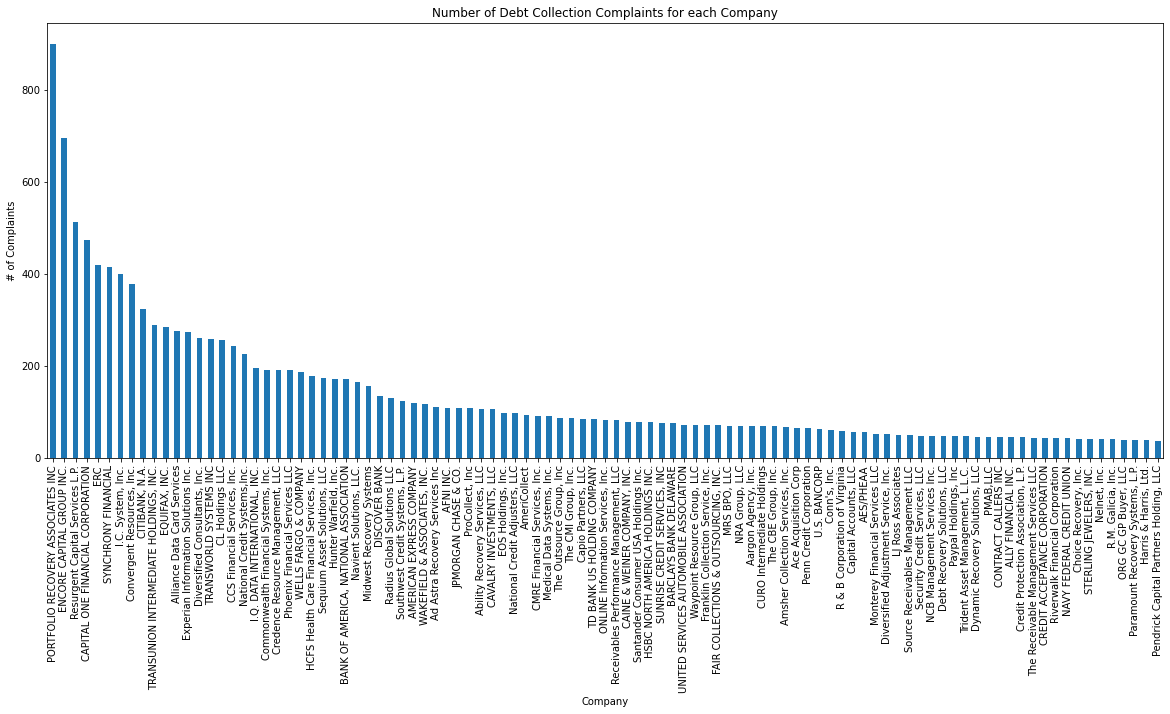

In [36]:
# call top_companies_bar_chart function
top_companies_bar_chart(df_orig);

## Initial split!
- to focus on the ~80% of complaints generated by ~20% of companies
- means removing companies that have fewer than 10 complaints

In [56]:
# call initial_split function
df_split = initial_split(df_complaint_num, df_orig)
df_split

,orig_index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,0,2020-05-07,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,I received an alert from XXXX XXXX on XX/XX/XX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",LA,700XX,None,Consent provided,Web,05/07/20,Closed with explanation,Yes,NaN,3642003
1,2,2020-02-11,Debt collection,Other debt,Took or threatened to take negative or legal a...,Seized or attempted to seize your property,See uploaded document dated XXXX ; CHASE BANK ...,None,JPMORGAN CHASE & CO.,GA,301XX,None,Consent provided,Web,02/11/20,Closed with explanation,Yes,NaN,3527527
2,3,2020-05-27,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,On XX/XX/XXXX I pulled my credit report and sa...,Company believes it acted appropriately as aut...,Monterey Financial Services LLC,NY,None,None,Consent provided,Web,05/27/20,Closed with explanation,Yes,NaN,3670227
3,4,2020-01-11,Debt collection,Other debt,Written notification about debt,Didn't receive notice of right to dispute,My XXXX ( XXXX ) Account number for Internet s...,None,AFNI INC.,FL,320XX,None,Consent provided,Web,01/11/20,Closed with explanation,Yes,NaN,3492864
4,5,2020-01-22,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,AMCOL Systems ( a debt collector ) reported a ...,None,"AMCOL Systems, Inc.",TX,775XX,None,Consent provided,Web,01/22/20,Closed with explanation,Yes,NaN,3504908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151,21825,2020-05-23,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,"I was made aware, that once again, XXXX XXXX c...",Company has responded to the consumer and the ...,The Receivable Management Services LLC,WV,258XX,None,Consent provided,Web,05/23/20,Closed with explanation,Yes,NaN,3666313
18152,21827,2020-05-03,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,using Lowe 's Advantage card I made online fro...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,WA,981XX,None,Consent provided,Web,05/03/20,Closed with monetary relief,Yes,NaN,3635213
18153,21828,2020-04-05,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,In XX/XX/XXXX I paid the full amount of my XXX...,None,Alliance Data Card Services,TX,None,None,Consent provided,Web,04/05/20,Closed with non-monetary relief,Yes,NaN,3593729
18154,21829,2020-03-28,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,XX/XX/XXXX my sister called to inform me that ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,934XX,None,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3584339


In [57]:
# check number of companies in df_split
# 337 is the right number!
df_split['Company'].value_counts()

PORTFOLIO RECOVERY ASSOCIATES INC            900
ENCORE CAPITAL GROUP INC.                    694
Resurgent Capital Services L.P.              512
CAPITAL ONE FINANCIAL CORPORATION            473
ERC                                          418
                                            ... 
Retrieval-Masters Creditors Bureau, Inc.      10
Fein, Such, Kahn & Shepard, P.C.              10
NELSON AND KENNARD                            10
Preferred Collection and Management, Inc.     10
BB&T CORPORATION                              10
Name: Company, Length: 337, dtype: int64

In [58]:
# pickle df_split
# df_split.to_pickle('df_split.pkl')

## Pre-process the data
- light cleaning
- use SpaCy for tokenization, lemmatization, part-of-speech tagging, dependency parsing